In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


from src.portfolio_selection_ga import PortfolioSelectionGA

In [2]:
def read_returns_data(file_path):
    data = pd.read_excel(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    return data.set_index('Date').sort_index().pct_change().dropna()

data = read_returns_data("../data/base_dados.xlsx")

In [3]:
def find_element_of_percentile(data, p):
    percentile = np.percentile(data, p)
    element = (data - percentile).abs().idxmin()
    return element

asset_list = []
for p in [0, 25, 50, 75, 100]:
    averages = data.mean()
    asset = find_element_of_percentile(averages, p)
    asset_list.append(asset)

    standard_deviations = data.std()
    asset = find_element_of_percentile(standard_deviations, p)
    asset_list.append(asset)

asset_list = list(set(asset_list))
data = data[asset_list]

In [5]:
S = 0.0005
t = 0.95

n = data.var()*t/S**2
n.sort_values()

TAEE4      2837.440005
GOAU3      9047.606864
BBDC4      9050.213469
CCRO3     10488.191207
UNIP6     14342.438278
PFRM3     16180.868725
ROMI3     22967.572521
PDGR3     71672.089895
INEP3     92328.198605
BRPR3    105034.774769
dtype: float64

In [6]:
simulation_solutions = []
for _ in range(500):
  num_simulations = 10000
  simulations = np.random.multivariate_normal(mean=data.mean().values,  cov = data.cov(),  size = num_simulations,  check_valid="raise")
  data_sim = pd.DataFrame(simulations, columns=data.columns)
  gurobi = PortfolioSelectionGA(data=data_sim, risk_aver=0.5)
  g_s = gurobi.optimize()
  simulation_solutions.append(g_s)

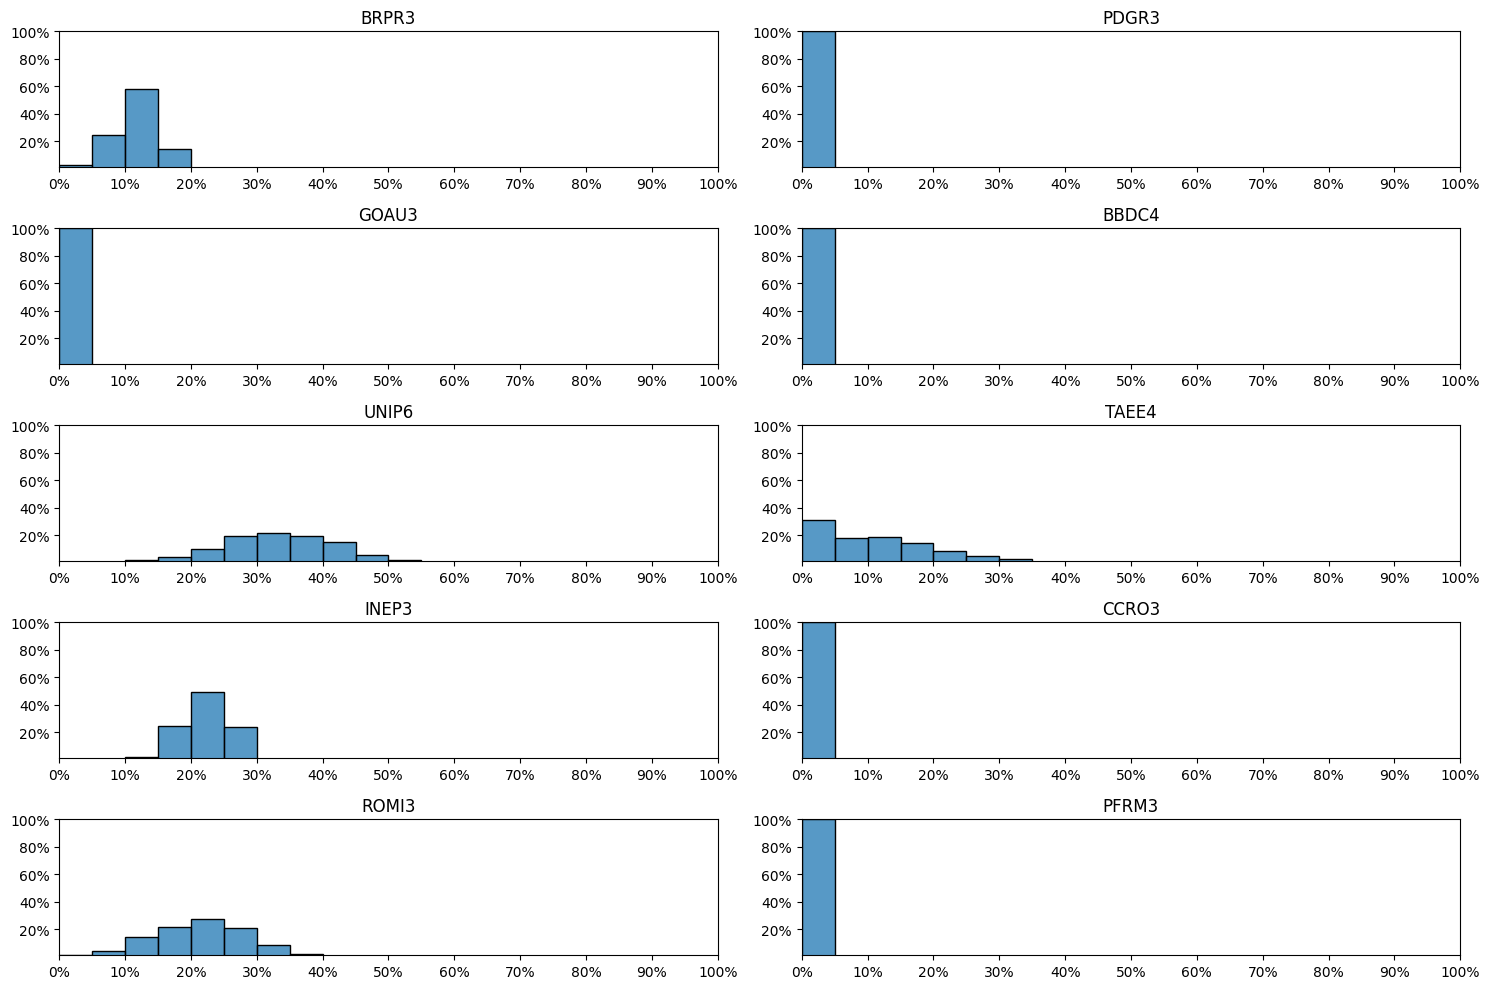

In [7]:
num_rows = 5
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i in range(data.shape[1]):
    row = i // num_cols
    col = i % num_cols
    
    values, bins = np.histogram(np.array(simulation_solutions)[:, i], bins=np.arange(0, 1.05, 0.05))
    percentages = (values / np.sum(values)) * 100
    
    sns.histplot(np.array(simulation_solutions)[:, i], bins=bins, ax=axes[row, col], stat='percent')
    axes[row, col].set_title(f"{data.columns[i]}")

    axes[row, col].set_xticks(np.arange(0, 1.05, 0.1))
    xticklabels = ["{:.0f}%".format(x*100) for x in axes[row, col].get_xticks()]
    axes[row, col].set_xticklabels(xticklabels)
    axes[row, col].set_yticks(np.arange(0, 101, 20))
    yticklabels = ["{:.0f}%".format(y) for y in axes[row, col].get_yticks()]
    axes[row, col].set_yticklabels(yticklabels)
    axes[row, col].set_ylim(1, 100)
    axes[row, col].set_xlim(0, 1)
    axes[row, col].set_ylabel(None)

plt.tight_layout()
plt.savefig("../images/portfolio_weigths_distribution_ga.png")
